<a href="https://colab.research.google.com/github/dhanush852/intro_to_deeplearning/blob/main/Homework1p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

problem 2a

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load dataset
df_train = pd.read_csv('https://raw.githubusercontent.com/dhanush852/intro_to_deeplearning/main/house-train.csv')

# Define useful columns and preprocess the dataset
useful_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
               'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage', 'WoodDeckSF',
               'OpenPorchSF']
target_col = 'SalePrice'

# Preprocess the dataset
df_train_prepro = df_train[useful_cols + [target_col]].fillna(df_train.mean())

# Split dataset into features and target
X = df_train_prepro[useful_cols]
y = df_train_prepro[target_col]

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert to PyTorch tensors and create data loaders
train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train.to_numpy()).view(-1, 1))
val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled), torch.FloatTensor(y_val.to_numpy()).view(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(len(useful_cols)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


<ipython-input-11-e987e0740119>:22: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_train_prepro = df_train[useful_cols + [target_col]].fillna(df_train.mean())


In [12]:
# Training loop
train_losses = []
val_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')



Epoch 1/100 - Train Loss: 38884745159.8904, Val Loss: 39650829971.2877
Epoch 2/100 - Train Loss: 38870528841.6438, Val Loss: 39613748602.7397
Epoch 3/100 - Train Loss: 38772519416.9863, Val Loss: 39410640082.4110
Epoch 4/100 - Train Loss: 38365040078.9041, Val Loss: 38691860143.3425
Epoch 5/100 - Train Loss: 37190067634.8493, Val Loss: 36899708451.0685
Epoch 6/100 - Train Loss: 34612479438.9041, Val Loss: 33305354240.0000
Epoch 7/100 - Train Loss: 29958008298.9589, Val Loss: 27498852492.2740
Epoch 8/100 - Train Loss: 23368243508.6027, Val Loss: 19844755203.5069
Epoch 9/100 - Train Loss: 15926461299.7260, Val Loss: 12585492325.6986
Epoch 10/100 - Train Loss: 10161181625.8630, Val Loss: 7782732344.1096
Epoch 11/100 - Train Loss: 7190010276.8219, Val Loss: 5830895759.7808
Epoch 12/100 - Train Loss: 6247362114.6301, Val Loss: 5118662633.2055
Epoch 13/100 - Train Loss: 5902444593.0959, Val Loss: 4713355609.4247
Epoch 14/100 - Train Loss: 5668188265.2055, Val Loss: 4605150651.6164
Epoch 15/1

In [13]:
# Model evaluation (optional here)
# Save model
torch.save(model.state_dict(), 'model_optimized.pth')

# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')

Total parameters: 11905


In [16]:
with torch.no_grad():
    y_pred = model(torch.FloatTensor(X_val_scaled).to(device))
    rmse = torch.sqrt(torch.nn.functional.mse_loss(y_pred, torch.FloatTensor(y_val.to_numpy()).view(-1, 1).to(device)))
    print(f'RMSE: {rmse:.4f}')


RMSE: 36464.9453


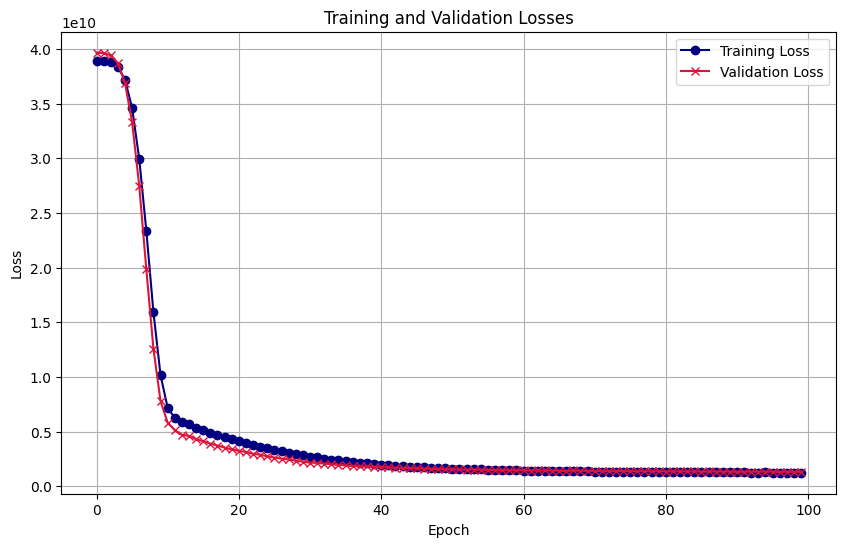

In [17]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(train_losses, label='Training Loss', color='navy', marker='o')
plt.plot(val_losses, label='Validation Loss', color='crimson', marker='x')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

problem 2.b

In [62]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/dhanush852/intro_to_deeplearning/main/house-train.csv')


In [63]:
from sklearn.model_selection import train_test_split


In [64]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

In [65]:

# Define columns
useful_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
               'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage', 'WoodDeckSF',
               'OpenPorchSF']
target_col = 'SalePrice'

# Preprocessing function
def preprocess_data(df, useful_cols, target_col, scaler=None, fit_scaler=False):
    df_prepro = df[useful_cols + [target_col]].copy()
    # Separate numeric and categorical columns
    numeric_cols = df_prepro.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = list(set(useful_cols) - set(numeric_cols))

    # Fill missing values
    df_prepro[numeric_cols] = df_prepro[numeric_cols].fillna(df[numeric_cols].mean())
    for col in categorical_cols:
        df_prepro[col] = df_prepro[col].fillna(df[col].mode()[0])

    # One-hot encoding
    df_prepro = pd.get_dummies(df_prepro, columns=categorical_cols, drop_first=True)

    # Split features and target
    X = df_prepro.drop(target_col, axis=1)
    y = df_prepro[target_col]

    # Scale features
    if fit_scaler:
        scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X) if scaler else X

    return X_scaled, y, scaler



In [66]:
# Preprocess training data
X_train, y_train, scaler = preprocess_data(df_train, useful_cols, target_col, fit_scaler=True)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val, y_val, _ = preprocess_data(df_val, useful_cols, target_col, scaler=scaler, fit_scaler=False)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

In [67]:
# Create TensorDatasets and DataLoaders for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(X_train_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [68]:

train_losses = []
val_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1/100 - Train Loss: 38884048727.6712, Val Loss: 39642009712.2192
Epoch 2/100 - Train Loss: 38704437500.4931, Val Loss: 38783106286.4658
Epoch 3/100 - Train Loss: 33044839409.9726, Val Loss: 20408325105.9726
Epoch 4/100 - Train Loss: 9410010083.9452, Val Loss: 2943401563.1781
Epoch 5/100 - Train Loss: 4098796158.2466, Val Loss: 2268418384.6575
Epoch 6/100 - Train Loss: 3166808814.4658, Val Loss: 2638516834.1918
Epoch 7/100 - Train Loss: 4264006131.7260, Val Loss: 2079824522.5205
Epoch 8/100 - Train Loss: 2583493537.3151, Val Loss: 2000113881.4247
Epoch 9/100 - Train Loss: 2310466000.6575, Val Loss: 1834451706.7397
Epoch 10/100 - Train Loss: 2118997055.1233, Val Loss: 1916738237.3699
Epoch 11/100 - Train Loss: 2071640668.9315, Val Loss: 1711871950.9041
Epoch 12/100 - Train Loss: 1923339584.8767, Val Loss: 1743949182.2466
Epoch 13/100 - Train Loss: 1841321016.1096, Val Loss: 1653257757.8082
Epoch 14/100 - Train Loss: 1821094915.5068, Val Loss: 1654316959.5616
Epoch 15/100 - Train Lo

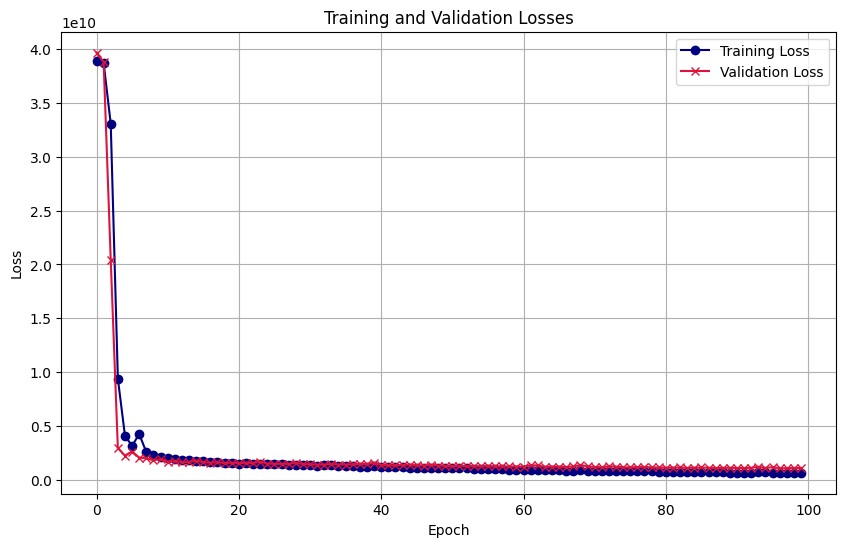

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='navy', marker='o')
plt.plot(val_losses, label='Validation Loss', color='crimson', marker='x')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [70]:
with torch.no_grad():
    y_pred = model(torch.FloatTensor(X_val_scaled).to(device))
    rmse = torch.sqrt(torch.nn.functional.mse_loss(y_pred, torch.FloatTensor(y_val.to_numpy()).view(-1, 1).to(device)))
    print(f'RMSE: {rmse:.4f}')


RMSE: 33377.4453


In [57]:
class Neuralnet(nn.Module):
    def __init__(self, input_size):
        super(Neuralnet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.network(x)


In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Neuralnet(X_train_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [59]:

train_losses = []
val_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1/100 - Train Loss: 38883409527.2329, Val Loss: 39637111625.6438
Epoch 2/100 - Train Loss: 38657390479.7808, Val Loss: 38509329085.3699
Epoch 3/100 - Train Loss: 31640397038.4658, Val Loss: 16847603796.1644
Epoch 4/100 - Train Loss: 8233929875.2877, Val Loss: 3576295385.4247
Epoch 5/100 - Train Loss: 4770189110.3562, Val Loss: 2265839642.3014
Epoch 6/100 - Train Loss: 3312959530.0822, Val Loss: 2643359570.4110
Epoch 7/100 - Train Loss: 2843016290.1918, Val Loss: 2006898526.6849
Epoch 8/100 - Train Loss: 2469854238.6849, Val Loss: 1918992220.9315
Epoch 9/100 - Train Loss: 2246432606.6849, Val Loss: 1890037404.0548
Epoch 10/100 - Train Loss: 2198984660.1644, Val Loss: 2054805274.3014
Epoch 11/100 - Train Loss: 2013117551.3425, Val Loss: 1738887257.4247
Epoch 12/100 - Train Loss: 1888339035.1781, Val Loss: 1800885151.5616
Epoch 13/100 - Train Loss: 1815064440.9863, Val Loss: 1678509560.9863
Epoch 14/100 - Train Loss: 1753039219.7260, Val Loss: 1659358523.6164
Epoch 15/100 - Train Lo

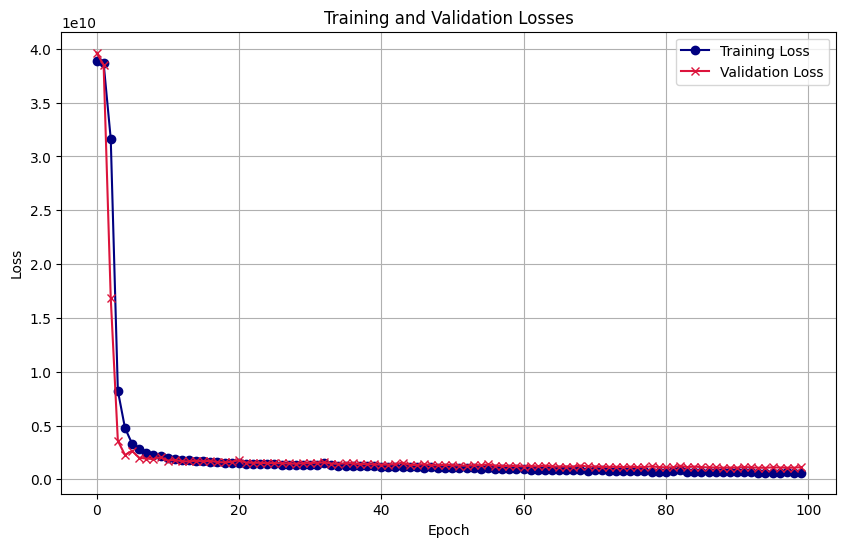

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='navy', marker='o')
plt.plot(val_losses, label='Validation Loss', color='crimson', marker='x')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [61]:
with torch.no_grad():
    y_pred = model(torch.FloatTensor(X_val_scaled).to(device))
    rmse = torch.sqrt(torch.nn.functional.mse_loss(y_pred, torch.FloatTensor(y_val.to_numpy()).view(-1, 1).to(device)))
    print(f'RMSE: {rmse:.4f}')

RMSE: 33661.5312
